# 模型选择、欠拟合和过拟合

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

/opt/anaconda3/envs/cs224n/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/cs224n/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <9B280146-BBD7-3F77-9873-F9740F2A5329> /opt/anaconda3/envs/cs224n/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /opt/anaconda3/envs/cs224n/lib/python3.10/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


通过下面的三阶多项式来生成训练和测试数据的标签：
$$ y= 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6\frac{x^3}{3!} + \epsilon \text{  where  } \epsilon \text{服从正态分布} (0,0.1^2) $$

In [3]:
max_degree = 20
n_train, n_test = 100,100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5,1.2,-3.4,5.6]) # 产生一个20维的特征测试向量

features = np.random.normal(size=(n_train+n_test,1))
np.random.shuffle(features)
poly_features = np.power(features,np.arange(max_degree).reshape(1,-1))
for i in range(max_degree):
    poly_features[:,i] /= math.gamma(i+1)
labels = np.dot(poly_features,true_w)
labels += np.random.normal(scale=0.1,size=labels.shape)

true_w,features,poly_features,labels = [
    torch.tensor(x,dtype=torch.float32)
    for x in [true_w,features,poly_features,labels]
]

features[:2],poly_features[:2,:],labels[:2]

(tensor([[-0.7002],
         [-1.8518]]),
 tensor([[ 1.0000e+00, -7.0024e-01,  2.4517e-01, -5.7225e-02,  1.0018e-02,
          -1.4030e-03,  1.6374e-04, -1.6379e-05,  1.4337e-06, -1.1155e-07,
           7.8109e-09, -4.9722e-10,  2.9015e-11, -1.5629e-12,  7.8170e-14,
          -3.6492e-15,  1.5971e-16, -6.5783e-18,  2.5591e-19, -9.4315e-21],
         [ 1.0000e+00, -1.8518e+00,  1.7147e+00, -1.0584e+00,  4.9001e-01,
          -1.8149e-01,  5.6014e-02, -1.4818e-02,  3.4302e-03, -7.0580e-04,
           1.3070e-04, -2.2004e-05,  3.3956e-06, -4.8371e-07,  6.3982e-08,
          -7.8990e-09,  9.1424e-10, -9.9590e-11,  1.0246e-11, -9.9862e-13]]),
 tensor([ 3.0470, -9.0827]))

实现一个函数来评估模型在给定数据集上的损失

In [4]:
def evaluate_loss(net,data_iter,loss):
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)
    for X,y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out,y)
        metric.add(l.sum(),l.numel())
    return metric[0] / metric[1]

定义训练函数

In [22]:
def train(train_features,test_features,train_labels,test_labels,num_epochs=800):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape,1,bias=False))
    batch_size = min(10,train_labels.shape[0])
    train_iter = d2l.load_array((train_features,train_labels.reshape(-1,1)),batch_size=batch_size)
    test_iter = d2l.load_array((test_features,test_labels.reshape(-1,1)),batch_size=batch_size,is_train=False)
    trainer = torch.optim.SGD(net.parameters(),lr=0.01)
    animator = d2l.Animator(xlabel='epoch',ylabel='loss',yscale='log',xlim=[1,num_epochs],ylim=[1e-3,1e2],legend=['train','test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net,train_iter,loss,trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch+1,(evaluate_loss(net,train_iter,loss),evaluate_loss(net,test_iter,loss)))
    print('weight:',net[0].weight.data.numpy())

三阶多项式函数拟合(正态)

weight: [[ 4.994076   1.19941   -3.3988528  5.599934 ]]


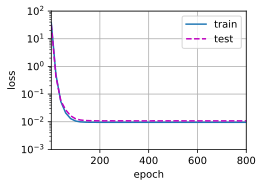

In [23]:
train(poly_features[:n_train,:4],poly_features[n_train:,:4],labels[:n_train],labels[n_train:])

## 欠拟合

weight: [[2.6769655 5.742435 ]]


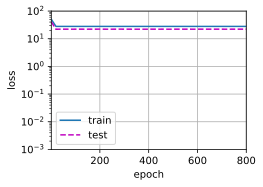

In [24]:
## 数据没有给好
train(poly_features[:n_train,:2],poly_features[n_train:,:2],labels[:n_train],labels[n_train:])

## 过拟合

weight: [[ 4.994345    1.2177571  -3.394647    5.47755    -0.11102872  0.46769235
   0.67552716 -0.18934722  0.02763834  0.03342133 -0.03598562 -0.17323077
   0.08790579 -0.02652876  0.18480355 -0.19267707 -0.13498214 -0.04878547
   0.01434988  0.04998666]]


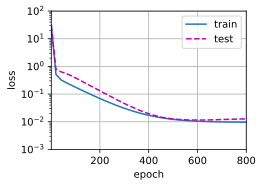

In [25]:
train(poly_features[:n_train,:],poly_features[n_train:,:],labels[:n_train],labels[n_train:])